In [1]:
import xarray as xr
import numpy as np
from dask.distributed import Client, LocalCluster
client = Client(n_workers=10,threads_per_worker=10,processes=True)
client

/home/joedhsu/.conda/envs/proj1_tropdiag/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 39713 instead
  warnings.warn(


<Client: 'tcp://127.0.0.1:34227' processes=10 threads=100, memory=67.54 GB>

# User input

In [2]:
# directory with input data
diri = "/maloney-scratch/joedhsu/proj1/data/sst_locking/"

# input file name.  code assumes full time seires in single file
fili = "SPCCSM3.TS.daily.0004-0023.nc"

# directory for output data
diro = "/maloney-scratch/joedhsu/proj1/data/sst_locking/"

#  output filename prefix (usually includes model and/or simulation details)
Center = "NCAR"

#  output filename prefix (usually includes model and/or simulation details)
Model = "SPCCSM"

# time coordinate variable name
timeName = "time" # units should be similar to "days since YYYY-MM-DD" or "hours since YYYY-MM-DD-HH:MM"

# longitude coordinate variable name
lonName = "lon"

# latitude coordinate variable name
latName = "lat"

#  surface temperature or equivalent variable name
varName = "TS"

#  land surface included?  Enter True or False (no quotation marks)
landData = True

#  skin temperature or foundation temperature?  enter "skin" or "foundation" (inlcude quotes)
sstType = "skin"

#  number of days per year (typically 365, sometimes 360)
DaysPerYear = 365 # some models have 360-day years.  Use 365 if Leap Days included

# Data IO

In [3]:
ds = xr.open_dataset(diri+fili,use_cftime=True)

In [4]:
# ----- skin or foundation SST?
if sstType != "skin" and sstType != "foundation" : 
    print("********* ABORT.  sstType is case-sensitive")
    print("          Must be 'skin' or 'foundation'")

if sstType == "foundation" :
    ds[varName] = ds[varName] - 0.2 # estimate skin SST from foundation SST (C. A Clayson, personal communication)

# Land masking

In [5]:
from ocean_mask import ocn_mask
 
da_omask_regrid = ocn_mask(ds[varName])
da_lmask_regrid = da_omask_regrid.where(da_omask_regrid.notnull(),other=2)-1
da_lmask_regrid = da_lmask_regrid.where(da_lmask_regrid==1, other=0)

/home/joedhsu/.conda/envs/proj1_tropdiag/lib/python3.8/site-packages/xarray/core/dataarray.py:738: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return key in self.data
/home/joedhsu/.conda/envs/proj1_tropdiag/lib/python3.8/site-packages/xesmf/frontend.py:464: FutureWarning: ``output_sizes`` should be given in the ``dask_gufunc_kwargs`` parameter. It will be removed as direct parameter in a future version.
  dr_out = xr.apply_ufunc(


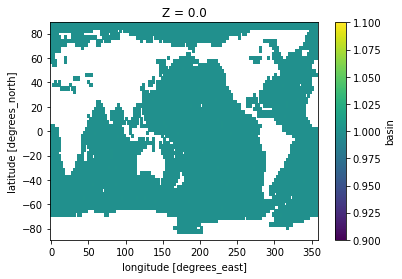

In [6]:
da_omask_regrid.plot()

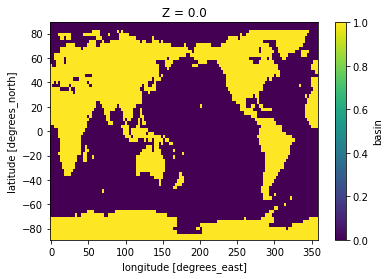

In [7]:
da_lmask_regrid.plot()

In [8]:
ds['%s_ocn'%varName] = ds[varName]*da_omask_regrid

# Create tropical mask

In [134]:
lat_lim = [25,35]

In [135]:
# tropical only shuffle
da_shuffle_mask = da_omask_regrid.copy()
da_original_mask = da_omask_regrid.copy()



In [136]:
tran_lat = da_shuffle_mask.lat.where((da_shuffle_mask.lat<=-np.min(lat_lim))&(da_shuffle_mask.lat>=-np.max(lat_lim)),drop=True).values
ntran_lat = len(tran_lat)
tran_value = np.linspace(0,1,ntran_lat)
for i in range(ntran_lat):
    da_shuffle_mask.loc[dict(lat = tran_lat[i])] = tran_value[i]

In [137]:
tran_lat = da_shuffle_mask.lat.where((da_shuffle_mask.lat>=np.min(lat_lim))&(da_shuffle_mask.lat<=np.max(lat_lim)),drop=True).values
ntran_lat = len(tran_lat)
tran_value = np.linspace(0,1,ntran_lat)
for i in range(ntran_lat):
    da_shuffle_mask.loc[dict(lat = tran_lat[i])] = tran_value[-i-1]

In [138]:
da_shuffle_mask = xr.where((da_shuffle_mask.lat>np.max(lat_lim))|(da_original_mask.lat<-np.max(lat_lim)),0,da_shuffle_mask)
da_shuffle_mask = da_shuffle_mask*da_omask_regrid

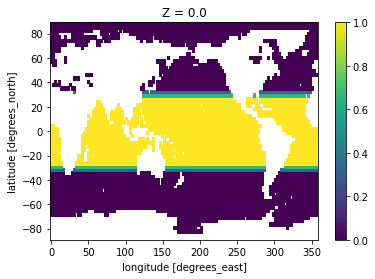

In [139]:
da_shuffle_mask.plot()

In [140]:
tran_lat = da_original_mask.lat.where((da_original_mask.lat<=-np.min(lat_lim))&(da_original_mask.lat>=-np.max(lat_lim)),drop=True).values
ntran_lat = len(tran_lat)
tran_value = np.linspace(0,1,ntran_lat)
for i in range(ntran_lat):
    da_original_mask.loc[dict(lat = tran_lat[i])] = tran_value[-i-1]

In [141]:
tran_lat = da_original_mask.lat.where((da_original_mask.lat>=np.min(lat_lim))&(da_original_mask.lat<=np.max(lat_lim)),drop=True).values
ntran_lat = len(tran_lat)
tran_value = np.linspace(0,1,ntran_lat)
for i in range(ntran_lat):
    da_original_mask.loc[dict(lat = tran_lat[i])] = tran_value[i]

In [142]:
da_original_mask = xr.where((da_original_mask.lat<np.min(lat_lim))&(da_original_mask.lat>-np.min(lat_lim)),0,da_original_mask)
da_original_mask = da_original_mask*da_omask_regrid

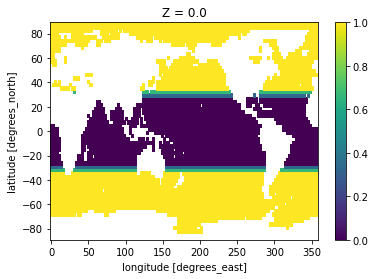

In [143]:
da_original_mask.plot()

# Calculate background signal

In [9]:
import importlib
import lanczos_filter
importlib.reload(lanczos_filter)
import lanczos_filter as lf

ds['%s_ocn_mean'%varName] = ds['%s_ocn'%varName].mean(dim=timeName)
ds['%s_ocn_nomean'%varName] = ds['%s_ocn'%varName]-ds['%s_ocn_mean'%varName]
ds['%s_ocn_bg'%varName] = lf.lanczos_low_pass(ds['%s_ocn_nomean'%varName], 201, 1/100., dim=timeName,opt='symm')+ds['%s_ocn_mean'%varName]
ds['%s_ocn_anom'%varName] = ds['%s_ocn'%varName]-ds['%s_ocn_bg'%varName]

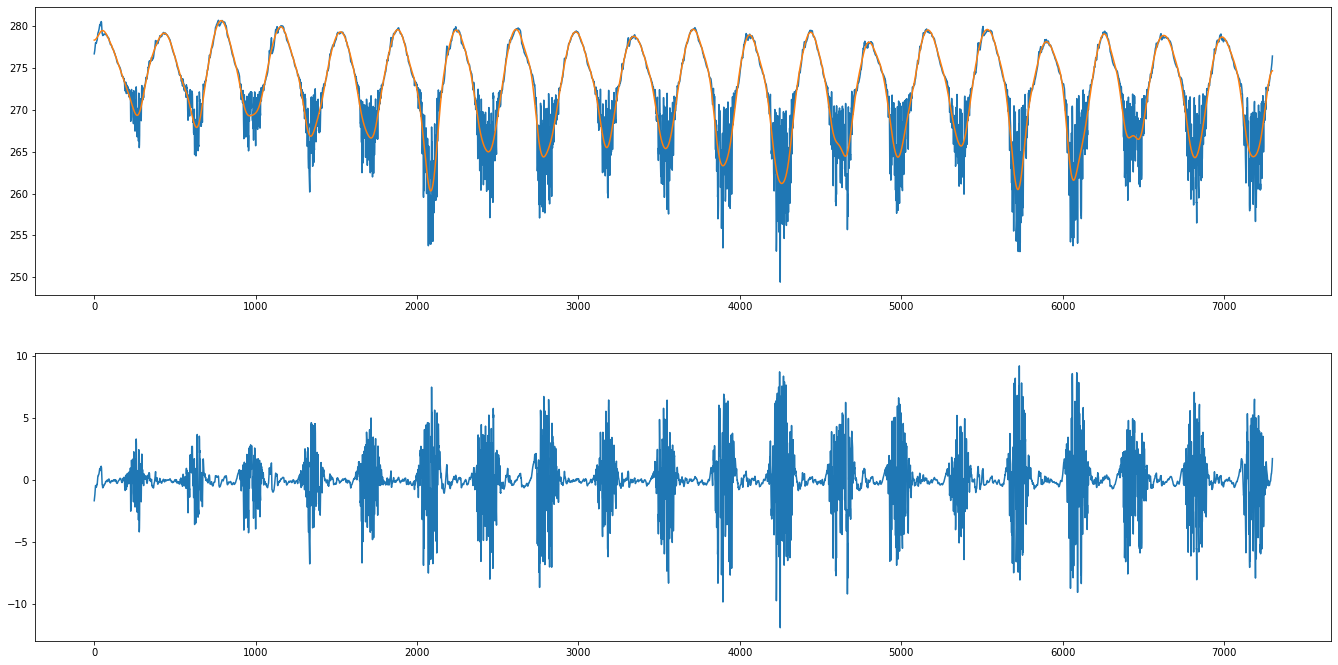

In [10]:
import matplotlib.pyplot as plt

#### plotting
fig=plt.figure(1)
ax1=fig.add_axes([0,0,3,1])
da_ori = ds['%s_ocn'%varName].isel(lon=20,lat=10)
da_test = ds['%s_ocn_bg'%varName].isel(lon=20,lat=10)
ax1.plot(da_ori.values)
ax1.plot(da_test.values)
ax2=fig.add_axes([0,-1.2,3,1])
da_ori = ds['%s_ocn_anom'%varName].isel(lon=20,lat=10)
ax2.plot(da_ori.values)

In [11]:
ds = ds.transpose(latName,lonName,timeName)
ds['dayofyear']=ds['%s.dayofyear'%timeName]

# Random Pattern

In [131]:
import random

da_randpatt = ds['%s_ocn_anom'%varName].copy()*np.nan

In [132]:
newindex_list = []
for i in range(1,DaysPerYear+1):
    newindex_list.append(np.where(ds['dayofyear']==i)[0])
    
newindex_all = []
newindex_all = np.array(np.append(newindex_all,newindex_list),dtype=int)

In [133]:
for i in range(DaysPerYear):
    dayindex = np.copy(newindex_list[i])
    random.shuffle(dayindex)
    da_randpatt[:,:,newindex_list[i]] = ds['%s_ocn_anom'%varName][:,:,dayindex].values

In [144]:
da_randpatt_trop = da_randpatt*da_shuffle_mask+ds['%s_ocn_anom'%varName]*da_original_mask

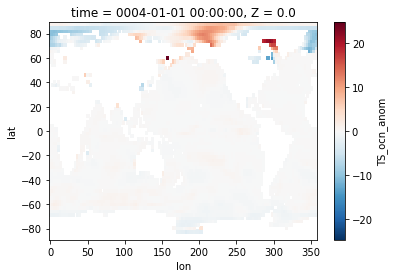

In [145]:
da_randpatt.isel(time=0).plot()

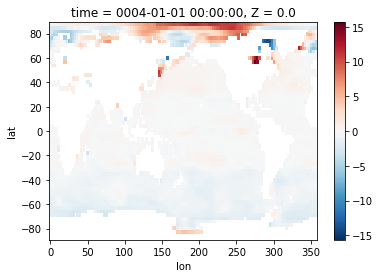

In [146]:
da_randpatt_trop.isel(time=0).plot()

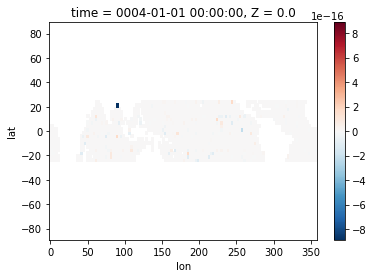

In [156]:
(da_randpatt_trop-da_randpatt).where((da_randpatt.lat<25)&(da_randpatt.lat>-25)).isel(time=0).plot()

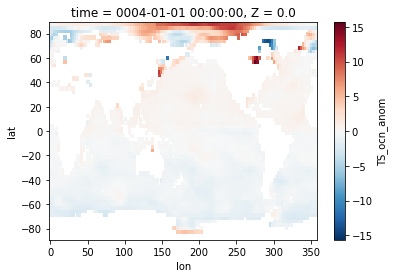

In [147]:
ds['%s_ocn_anom'%varName].isel(time=0).plot()

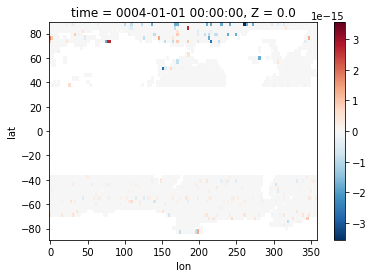

In [155]:
(da_randpatt_trop-ds['%s_ocn_anom'%varName]).where((da_randpatt.lat>35)|(da_randpatt.lat<-35)).isel(time=0).plot()

# Random single point

In [157]:
import random

da_randpt = ds['%s_ocn_anom'%varName].copy()*np.nan

In [159]:

for i in range(len(ds['%s'%lonName])):
    print("swapping pointwise on lon index %i"%i)
    for j in range(len(ds['%s'%latName])):
        if da_omask_regrid[j,i].notnull() and (ds['%s'%latName][j]>-np.max(lat_lim)) and (ds['%s'%latName][j]<np.max(lat_lim)) :
            for ii in range(DaysPerYear):
                dayindex = np.copy(newindex_list[ii])
                random.shuffle(dayindex)
                da_randpt[j,i,newindex_list[ii]] = ds['%s_ocn_anom'%varName][j,i,dayindex].values

swapping pointwise on lon index 0
swapping pointwise on lon index 1
swapping pointwise on lon index 2
swapping pointwise on lon index 3
swapping pointwise on lon index 4
swapping pointwise on lon index 5
swapping pointwise on lon index 6
swapping pointwise on lon index 7
swapping pointwise on lon index 8
swapping pointwise on lon index 9
swapping pointwise on lon index 10
swapping pointwise on lon index 11
swapping pointwise on lon index 12
swapping pointwise on lon index 13
swapping pointwise on lon index 14
swapping pointwise on lon index 15
swapping pointwise on lon index 16
swapping pointwise on lon index 17
swapping pointwise on lon index 18
swapping pointwise on lon index 19
swapping pointwise on lon index 20
swapping pointwise on lon index 21
swapping pointwise on lon index 22
swapping pointwise on lon index 23
swapping pointwise on lon index 24
swapping pointwise on lon index 25
swapping pointwise on lon index 26
swapping pointwise on lon index 27
swapping pointwise on lon inde

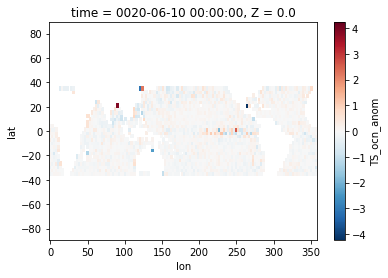

In [160]:
da_randpt.isel(time=6000).plot()

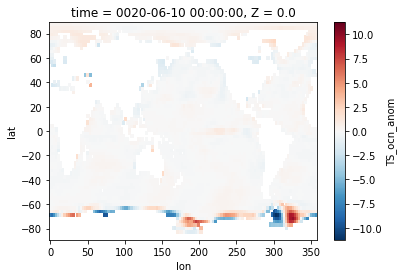

In [161]:
ds['%s_ocn_anom'%varName].isel(time=6000).plot()

In [162]:
da_randpt_trop = da_randpt.where(da_randpt.notnull(),other=0)*da_shuffle_mask+ds['%s_ocn_anom'%varName]*da_original_mask

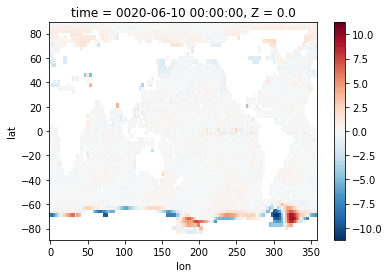

In [163]:
da_randpt_trop.isel(time=6000).plot()

# Random 5days

In [164]:
da_randpatt5days = ds['%s_ocn_anom'%varName].copy()*np.nan

In [165]:

for i in range(0,DaysPerYear,5):
    dayindex = np.copy(newindex_list[i])
    random.shuffle(dayindex)
    for newind,oldind in enumerate(dayindex):
        da_randpatt5days[:,:,newindex_list[i][newind]:newindex_list[i][newind]+5] = ds['%s_ocn_anom'%varName][:,:,oldind:oldind+5].values


In [166]:
da_randpatt5days_trop = da_randpatt5days*da_shuffle_mask+ds['%s_ocn_anom'%varName]*da_original_mask

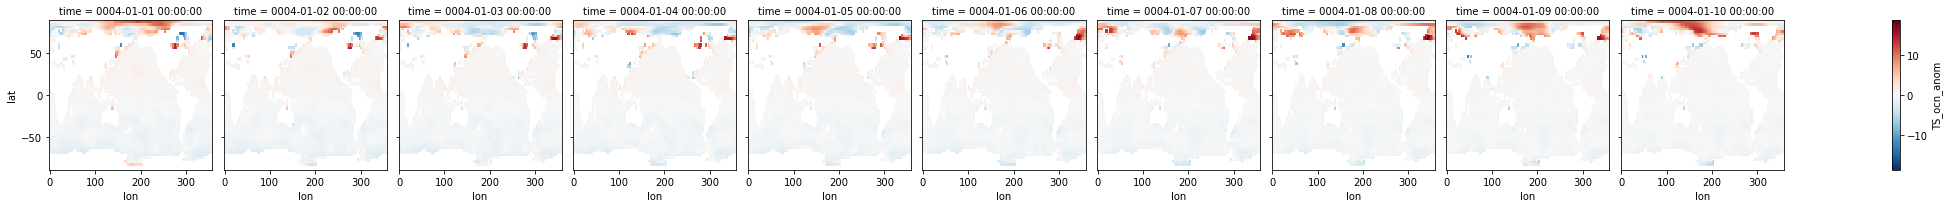

In [167]:
ds['%s_ocn_anom'%varName].isel(time=np.arange(0,10)).plot(col='time')

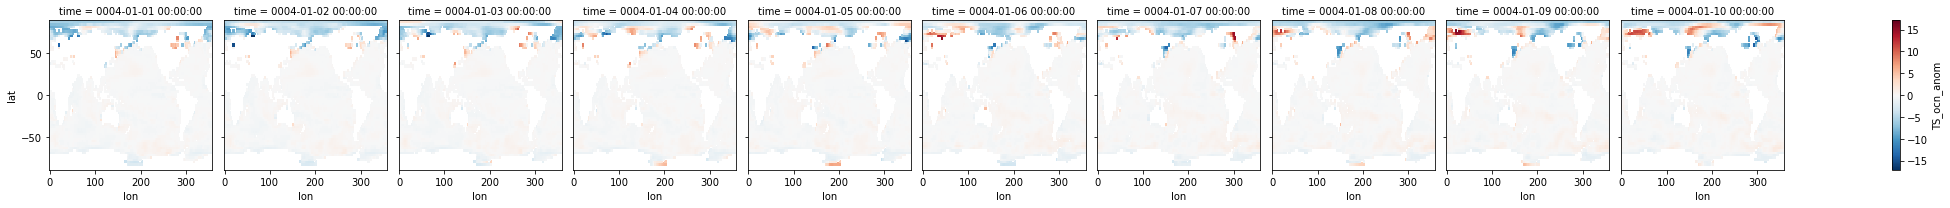

In [168]:
da_randpatt5days.isel(time=np.arange(0,10)).plot(col='time')

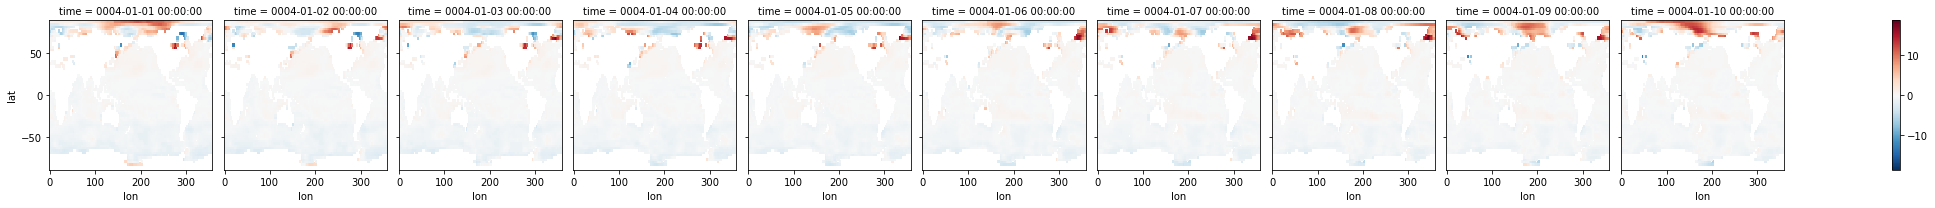

In [169]:
da_randpatt5days_trop.isel(time=np.arange(0,10)).plot(col='time')

# Putting Land points back

In [177]:
ds['RandPatt1d'] = (da_randpatt_trop+ds['%s_ocn_bg'%varName])
ds['RandPt1d'] = (da_randpt_trop+ds['%s_ocn_bg'%varName])
ds['RandPatt5d'] = (da_randpatt5days_trop+ds['%s_ocn_bg'%varName])

if landData :
    ds['RandPatt1d'] = ds['RandPatt1d'].where(ds['RandPatt1d'].notnull(),other=0.)
    ds['RandPt1d'] = ds['RandPt1d'].where(ds['RandPt1d'].notnull(),other=0.)
    ds['RandPatt5d'] = ds['RandPatt5d'].where(ds['RandPatt5d'].notnull(),other=0.)

    ds['RandPatt1d'] = da_lmask_regrid*ds['%s'%varName]+ds['RandPatt1d']
    ds['RandPt1d'] = da_lmask_regrid*ds['%s'%varName]+ds['RandPt1d']
    ds['RandPatt5d'] = da_lmask_regrid*ds['%s'%varName]+ds['RandPatt5d']

# Output file

In [179]:
# CGCM output
ds_output = xr.Dataset()
ds_output['TS_CGCM_bg'] = ds['%s_ocn_bg'%varName] 
ds_output['TS_CGCM_bg'].attrs["long_name"] = 'Original SST background'
ds_output['TS_CGCM_bg'].attrs["units"] = 'K'

ds_output['TS_CGCM_anom'] = ds['%s_ocn_anom'%varName]
ds_output['TS_CGCM_anom'].attrs["long_name"] = 'Original SSTA'
ds_output['TS_CGCM_anom'].attrs["units"] = 'K'

ds_output['TS_CGCM'] = ds['%s'%varName]
ds_output['TS_CGCM'].attrs["long_name"] = 'Orignal Surface temperature (radiative)'
ds_output['TS_CGCM'].attrs["units"] = 'K'

ds_output.to_netcdf('%s%s.%s.TS.CGCM.0004-0023.nc'%(diro,Center,Model))

# AGCM_1dRandPatt
ds_output = xr.Dataset()
ds_output['TS_AGCM_1dRandPatt_bg'] = ds['%s_ocn_bg'%varName] 
ds_output['TS_AGCM_1dRandPatt_bg'].attrs["long_name"] = 'Original SST background'
ds_output['TS_AGCM_1dRandPatt_bg'].attrs["units"] = 'K'

ds_output['TS_AGCM_1dRandPatt_anom'] = da_randpatt
ds_output['TS_AGCM_1dRandPatt_anom'].attrs["long_name"] = 'Pattern randomize SSTA'
ds_output['TS_AGCM_1dRandPatt_anom'].attrs["units"] = 'K'

ds_output['TS_AGCM_1dRandPatt'] = ds['RandPatt1d']
ds_output['TS_AGCM_1dRandPatt'].attrs["long_name"] = 'Pattern randomize SSTA + Original SST background + Original land surface temperature'
ds_output['TS_AGCM_1dRandPatt'].attrs["units"] = 'K'

ds_output.to_netcdf('%s%s.%s.TS.AGCM_1dRandPatt_trop.0004-0023.nc'%(diro,Center,Model))

# AGCM_5dRandPatt
ds_output = xr.Dataset()
ds_output['TS_AGCM_5dRandPatt_bg'] = ds['%s_ocn_bg'%varName] 
ds_output['TS_AGCM_5dRandPatt_bg'].attrs["long_name"] = 'Original SST background'
ds_output['TS_AGCM_5dRandPatt_bg'].attrs["units"] = 'K'

ds_output['TS_AGCM_5dRandPatt_anom'] = da_randpatt5days
ds_output['TS_AGCM_5dRandPatt_anom'].attrs["long_name"] = '5days Pattern randomize SSTA'
ds_output['TS_AGCM_5dRandPatt_anom'].attrs["units"] = 'K'

ds_output['TS_AGCM_5dRandPatt'] = ds['RandPatt5d']
ds_output['TS_AGCM_5dRandPatt'].attrs["long_name"] = '5days Pattern randomize SSTA + Original SST background + Original land surface temperature'
ds_output['TS_AGCM_5dRandPatt'].attrs["units"] = 'K'

ds_output.to_netcdf('%s%s.%s.TS.AGCM_5dRandPatt_trop.0004-0023.nc'%(diro,Center,Model))

# AGCM_1dRandPt
ds_output = xr.Dataset()
ds_output['TS_AGCM_1dRandpt_bg'] = ds['%s_ocn_bg'%varName] 
ds_output['TS_AGCM_1dRandpt_bg'].attrs["long_name"] = 'Original SST background'
ds_output['TS_AGCM_1dRandpt_bg'].attrs["units"] = 'K'

ds_output['TS_AGCM_1dRandpt_anom'] = da_randpt
ds_output['TS_AGCM_1dRandpt_anom'].attrs["long_name"] = 'Pointwise randomize SSTA'
ds_output['TS_AGCM_1dRandpt_anom'].attrs["units"] = 'K'

ds_output['TS_AGCM_1dRandPt'] = ds['RandPt1d']
ds_output['TS_AGCM_1dRandPt'].attrs["long_name"] = 'Pointwise randomize SSTA + Original SST background + Original land surface temperature'
ds_output['TS_AGCM_1dRandPt'].attrs["units"] = 'K'

ds_output.to_netcdf('%s%s.%s.TS.AGCM_1dRandPt_trop.0004-0023.nc'%(diro,Center,Model))


# Demo plots

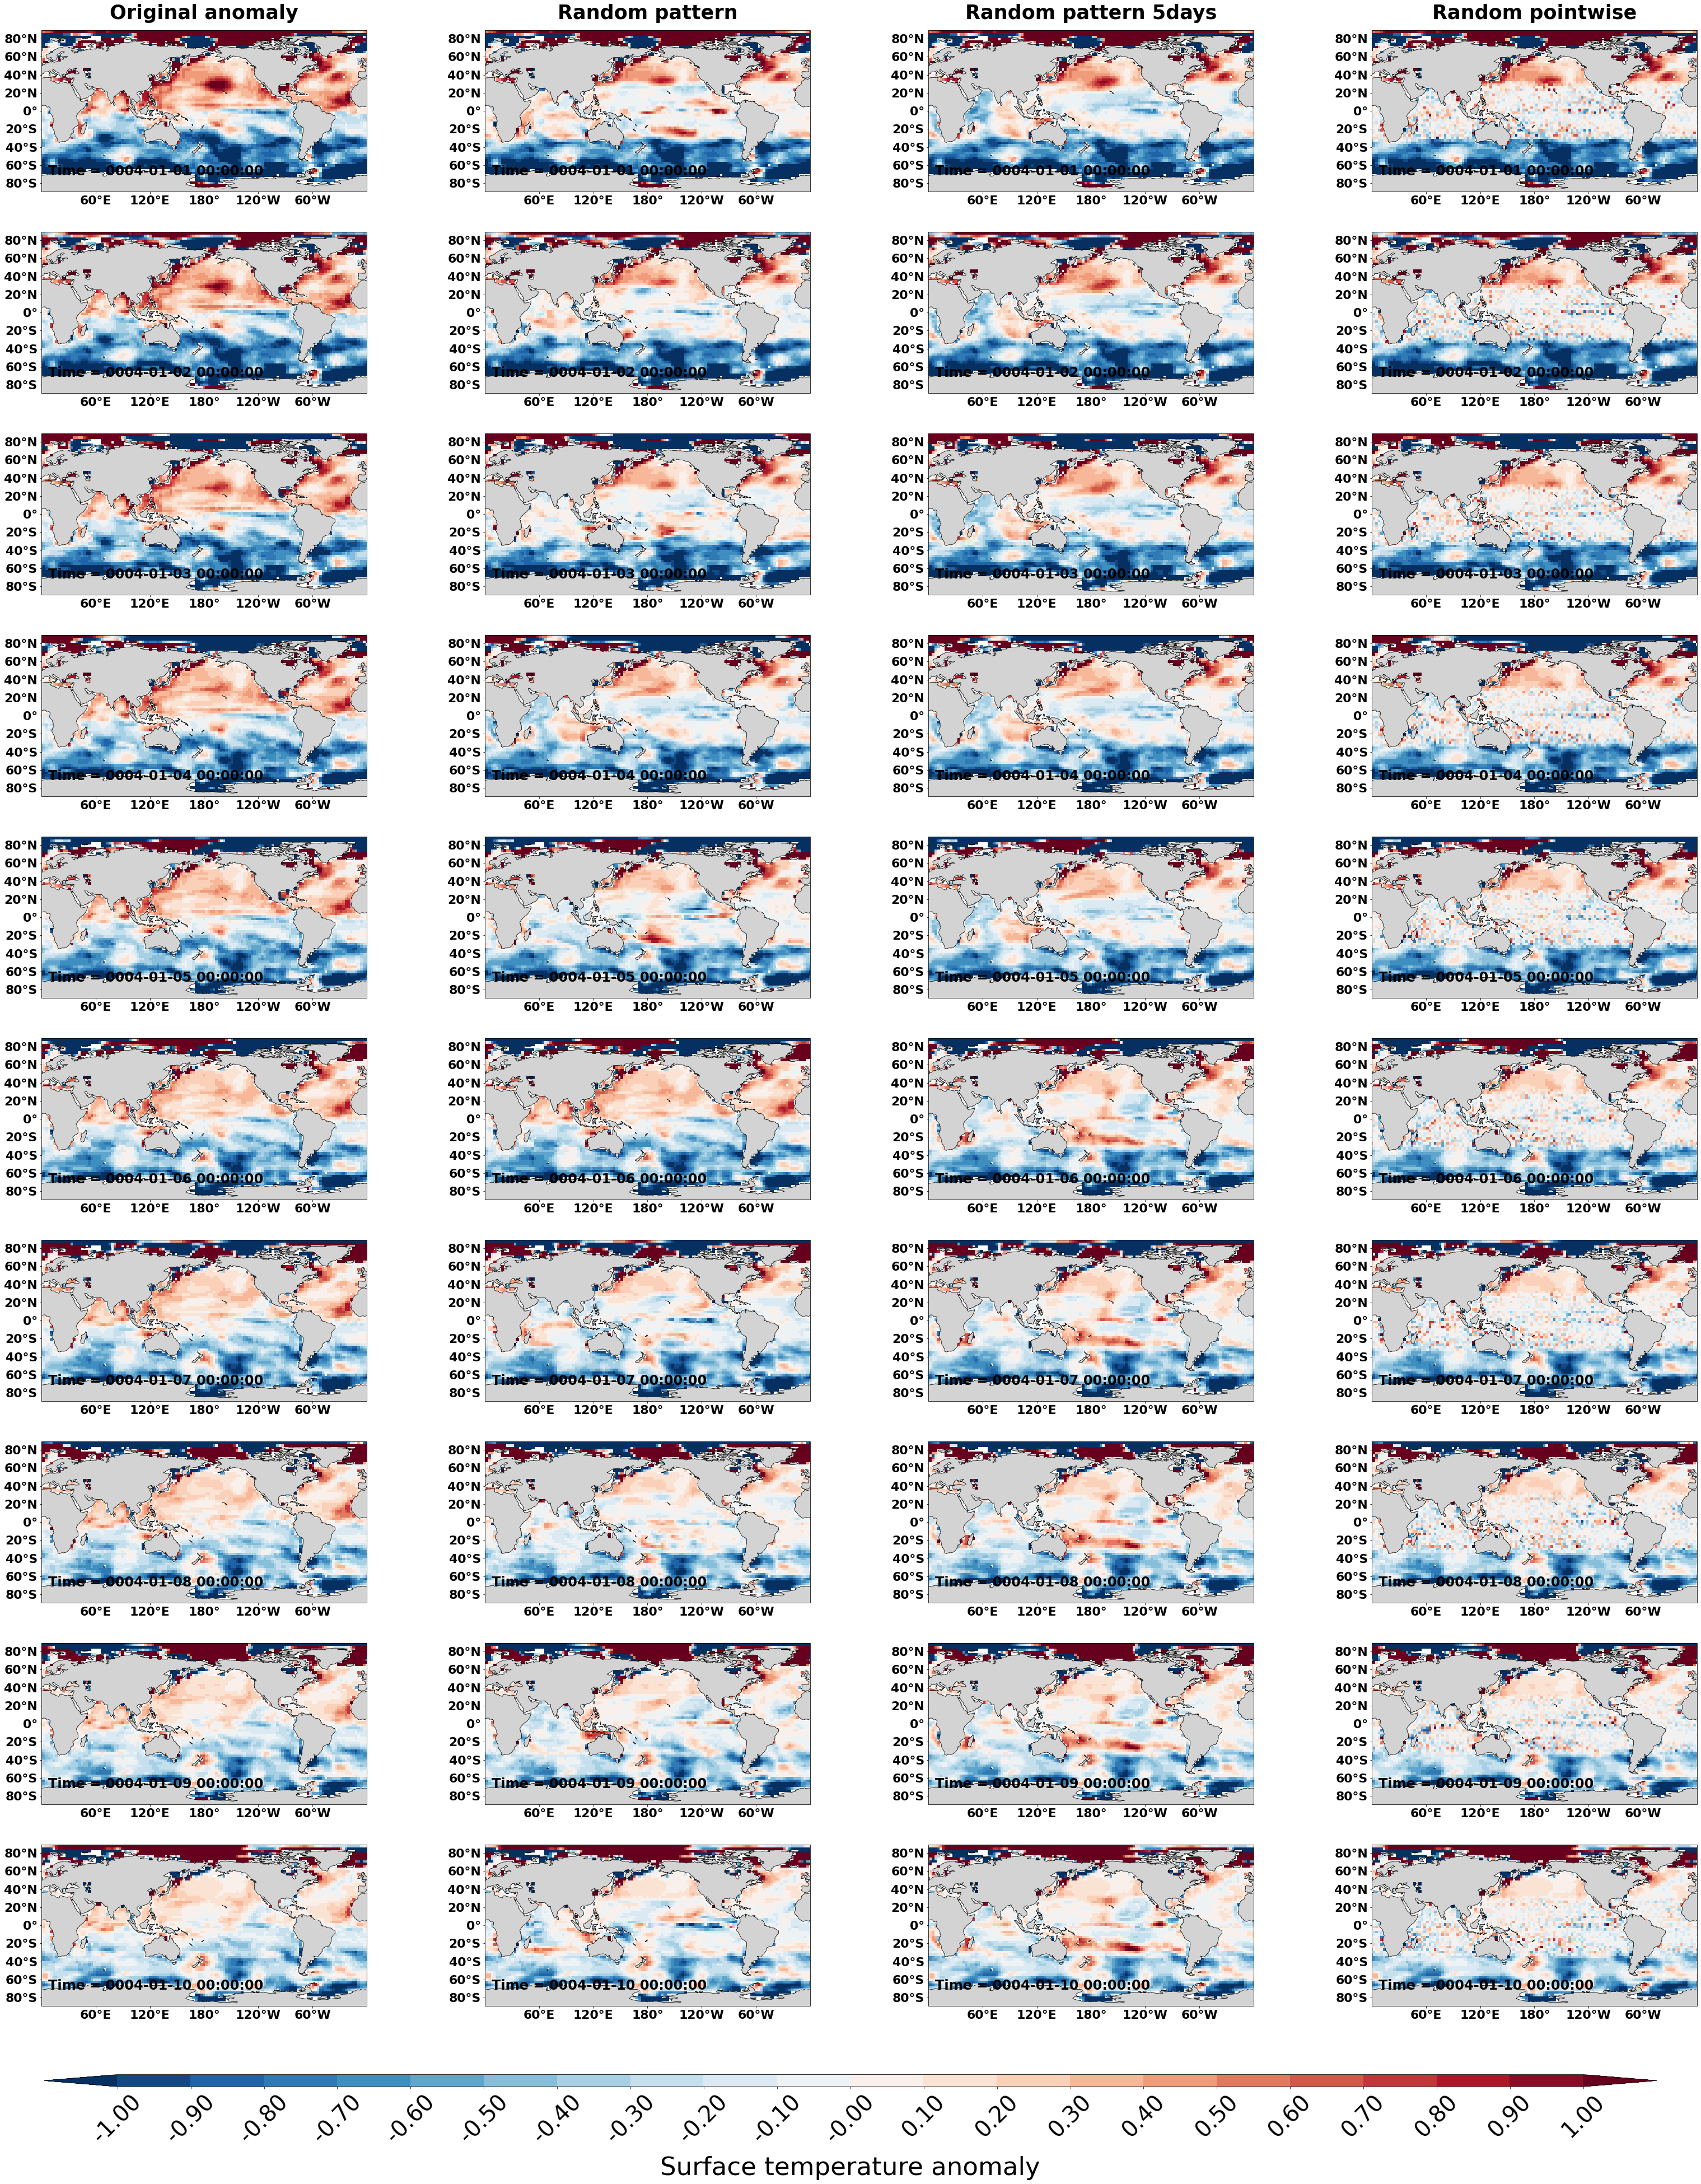

In [176]:
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
# from palettable.colorbrewer.diverging import BrBG_11

fig = plt.figure(2,figsize=(20,10))
devy = 0.5
dlevel = np.arange(-1, 1+0.01, 0.1)
timeindex = np.arange(0,10)


######################################## plotting ############################################
for nindex,timeindex in enumerate(timeindex):
    
    #### original ####
    ax2 = fig.add_axes([0,0-nindex*devy-0.4,1,0.4],projection=ccrs.PlateCarree(central_longitude=180))
    im = ds['%s_ocn_anom'%varName].isel(time=timeindex)\
           .plot.pcolormesh(x='lon',
                            y='lat',
                            ax=ax2, 
                            levels=dlevel, 
                            extend='both', 
                            cmap='RdBu_r',
                            transform=ccrs.PlateCarree(central_longitude=0))

    cb=im.colorbar
    cb.remove()
    ax2.coastlines(resolution='110m',linewidths=0.8)
    ax2.add_feature(cfeature.LAND,color='lightgrey')
    
    ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
    ax2.set_yticks([-80,-60,-40,-20,0,20,40,60,80], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-80,-60,-40,-20,0,20,40,60,80], color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()
    
    ax2.text(0.02,0.1, 'Time = %s'%ds['%s_ocn_anom'%varName].time.isel(time=timeindex).values,
             fontsize=24, color='k', weight='bold', transform=ax2.transAxes)
    

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
#     ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    if nindex == 0:
        ax2.set_title('Original anomaly', color='black', weight='bold',size=35,pad=20)
    else:
        ax2.set_title('', color='black', weight='bold',size=35,pad=20)
#     ax2.set_aspect('auto')
    
    
    #### random pattern ####
    ax2 = fig.add_axes([0+0.55,0-nindex*devy-0.4,1,0.4],projection=ccrs.PlateCarree(central_longitude=180))
    im = da_randpatt_trop.isel(time=timeindex)\
           .plot.pcolormesh(x='lon',
                            y='lat',
                            ax=ax2, 
                            levels=dlevel, 
                            extend='both', 
                            cmap='RdBu_r',
                            transform=ccrs.PlateCarree(central_longitude=0))

    cb=im.colorbar
    cb.remove()
    ax2.coastlines(resolution='110m',linewidths=0.8)
    ax2.add_feature(cfeature.LAND,color='lightgrey')
    
    ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
    ax2.set_yticks([-80,-60,-40,-20,0,20,40,60,80], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-80,-60,-40,-20,0,20,40,60,80], color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()
    
    ax2.text(0.02,0.1, 'Time = %s'%ds['%s_ocn_anom'%varName].time.isel(time=timeindex).values,
             fontsize=24, color='k', weight='bold', transform=ax2.transAxes)
    

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
#     ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    if nindex == 0:
        ax2.set_title('Random pattern', color='black', weight='bold',size=35,pad=20)
    else:
        ax2.set_title('', color='black', weight='bold',size=35,pad=20)
#     ax2.set_aspect('auto')

    #### random pattern 5days ####
    ax2 = fig.add_axes([0+0.55*2,0-nindex*devy-0.4,1,0.4],projection=ccrs.PlateCarree(central_longitude=180))
    im = da_randpatt5days_trop.isel(time=timeindex)\
           .plot.pcolormesh(x='lon',
                            y='lat',
                            ax=ax2, 
                            levels=dlevel, 
                            extend='both', 
                            cmap='RdBu_r',
                            transform=ccrs.PlateCarree(central_longitude=0))

    cb=im.colorbar
    cb.remove()
    ax2.coastlines(resolution='110m',linewidths=0.8)
    ax2.add_feature(cfeature.LAND,color='lightgrey')
    
    ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
    ax2.set_yticks([-80,-60,-40,-20,0,20,40,60,80], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-80,-60,-40,-20,0,20,40,60,80], color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()
    
    ax2.text(0.02,0.1, 'Time = %s'%ds['%s_ocn_anom'%varName].time.isel(time=timeindex).values,
             fontsize=24, color='k', weight='bold', transform=ax2.transAxes)
    

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
#     ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    if nindex == 0:
        ax2.set_title('Random pattern 5days', color='black', weight='bold',size=35,pad=20)
    else:
        ax2.set_title('', color='black', weight='bold',size=35,pad=20)
#     ax2.set_aspect('auto')

    #### random pointwise ####
    ax2 = fig.add_axes([0+0.55*3,0-nindex*devy-0.4,1,0.4],projection=ccrs.PlateCarree(central_longitude=180))
    im = da_randpt_trop.isel(time=timeindex)\
           .plot.pcolormesh(x='lon',
                            y='lat',
                            ax=ax2, 
                            levels=dlevel, 
                            extend='both', 
                            cmap='RdBu_r',
                            transform=ccrs.PlateCarree(central_longitude=0))

    cb=im.colorbar
    cb.remove()
    ax2.coastlines(resolution='110m',linewidths=0.8)
    ax2.add_feature(cfeature.LAND,color='lightgrey')
    
    ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
    ax2.set_yticks([-80,-60,-40,-20,0,20,40,60,80], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-80,-60,-40,-20,0,20,40,60,80], color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()
    
    ax2.text(0.02,0.1, 'Time = %s'%ds['%s_ocn_anom'%varName].time.isel(time=timeindex).values,
             fontsize=24, color='k', weight='bold', transform=ax2.transAxes)
    

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
#     ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    if nindex == 0:
        ax2.set_title('Random pointwise', color='black', weight='bold',size=35,pad=20)
    else:
        ax2.set_title('', color='black', weight='bold',size=35,pad=20)
#     ax2.set_aspect('auto')



cbaxes=fig.add_axes([0+0.4,0-nindex*devy-0.6,2,0.03])
cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
cbar.set_ticks(dlevel)
cbar.set_ticklabels(["%0.2f"%(n) for n in dlevel]) 
cbar.ax.tick_params(labelsize=40,rotation=45) 
cbar.set_label(label='Surface temperature anomaly',size=45, labelpad=15)



fig.savefig('SST_locking_global_anom_demo.png', dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', format=None,
                transparent=False, bbox_inches="tight", pad_inches=None)



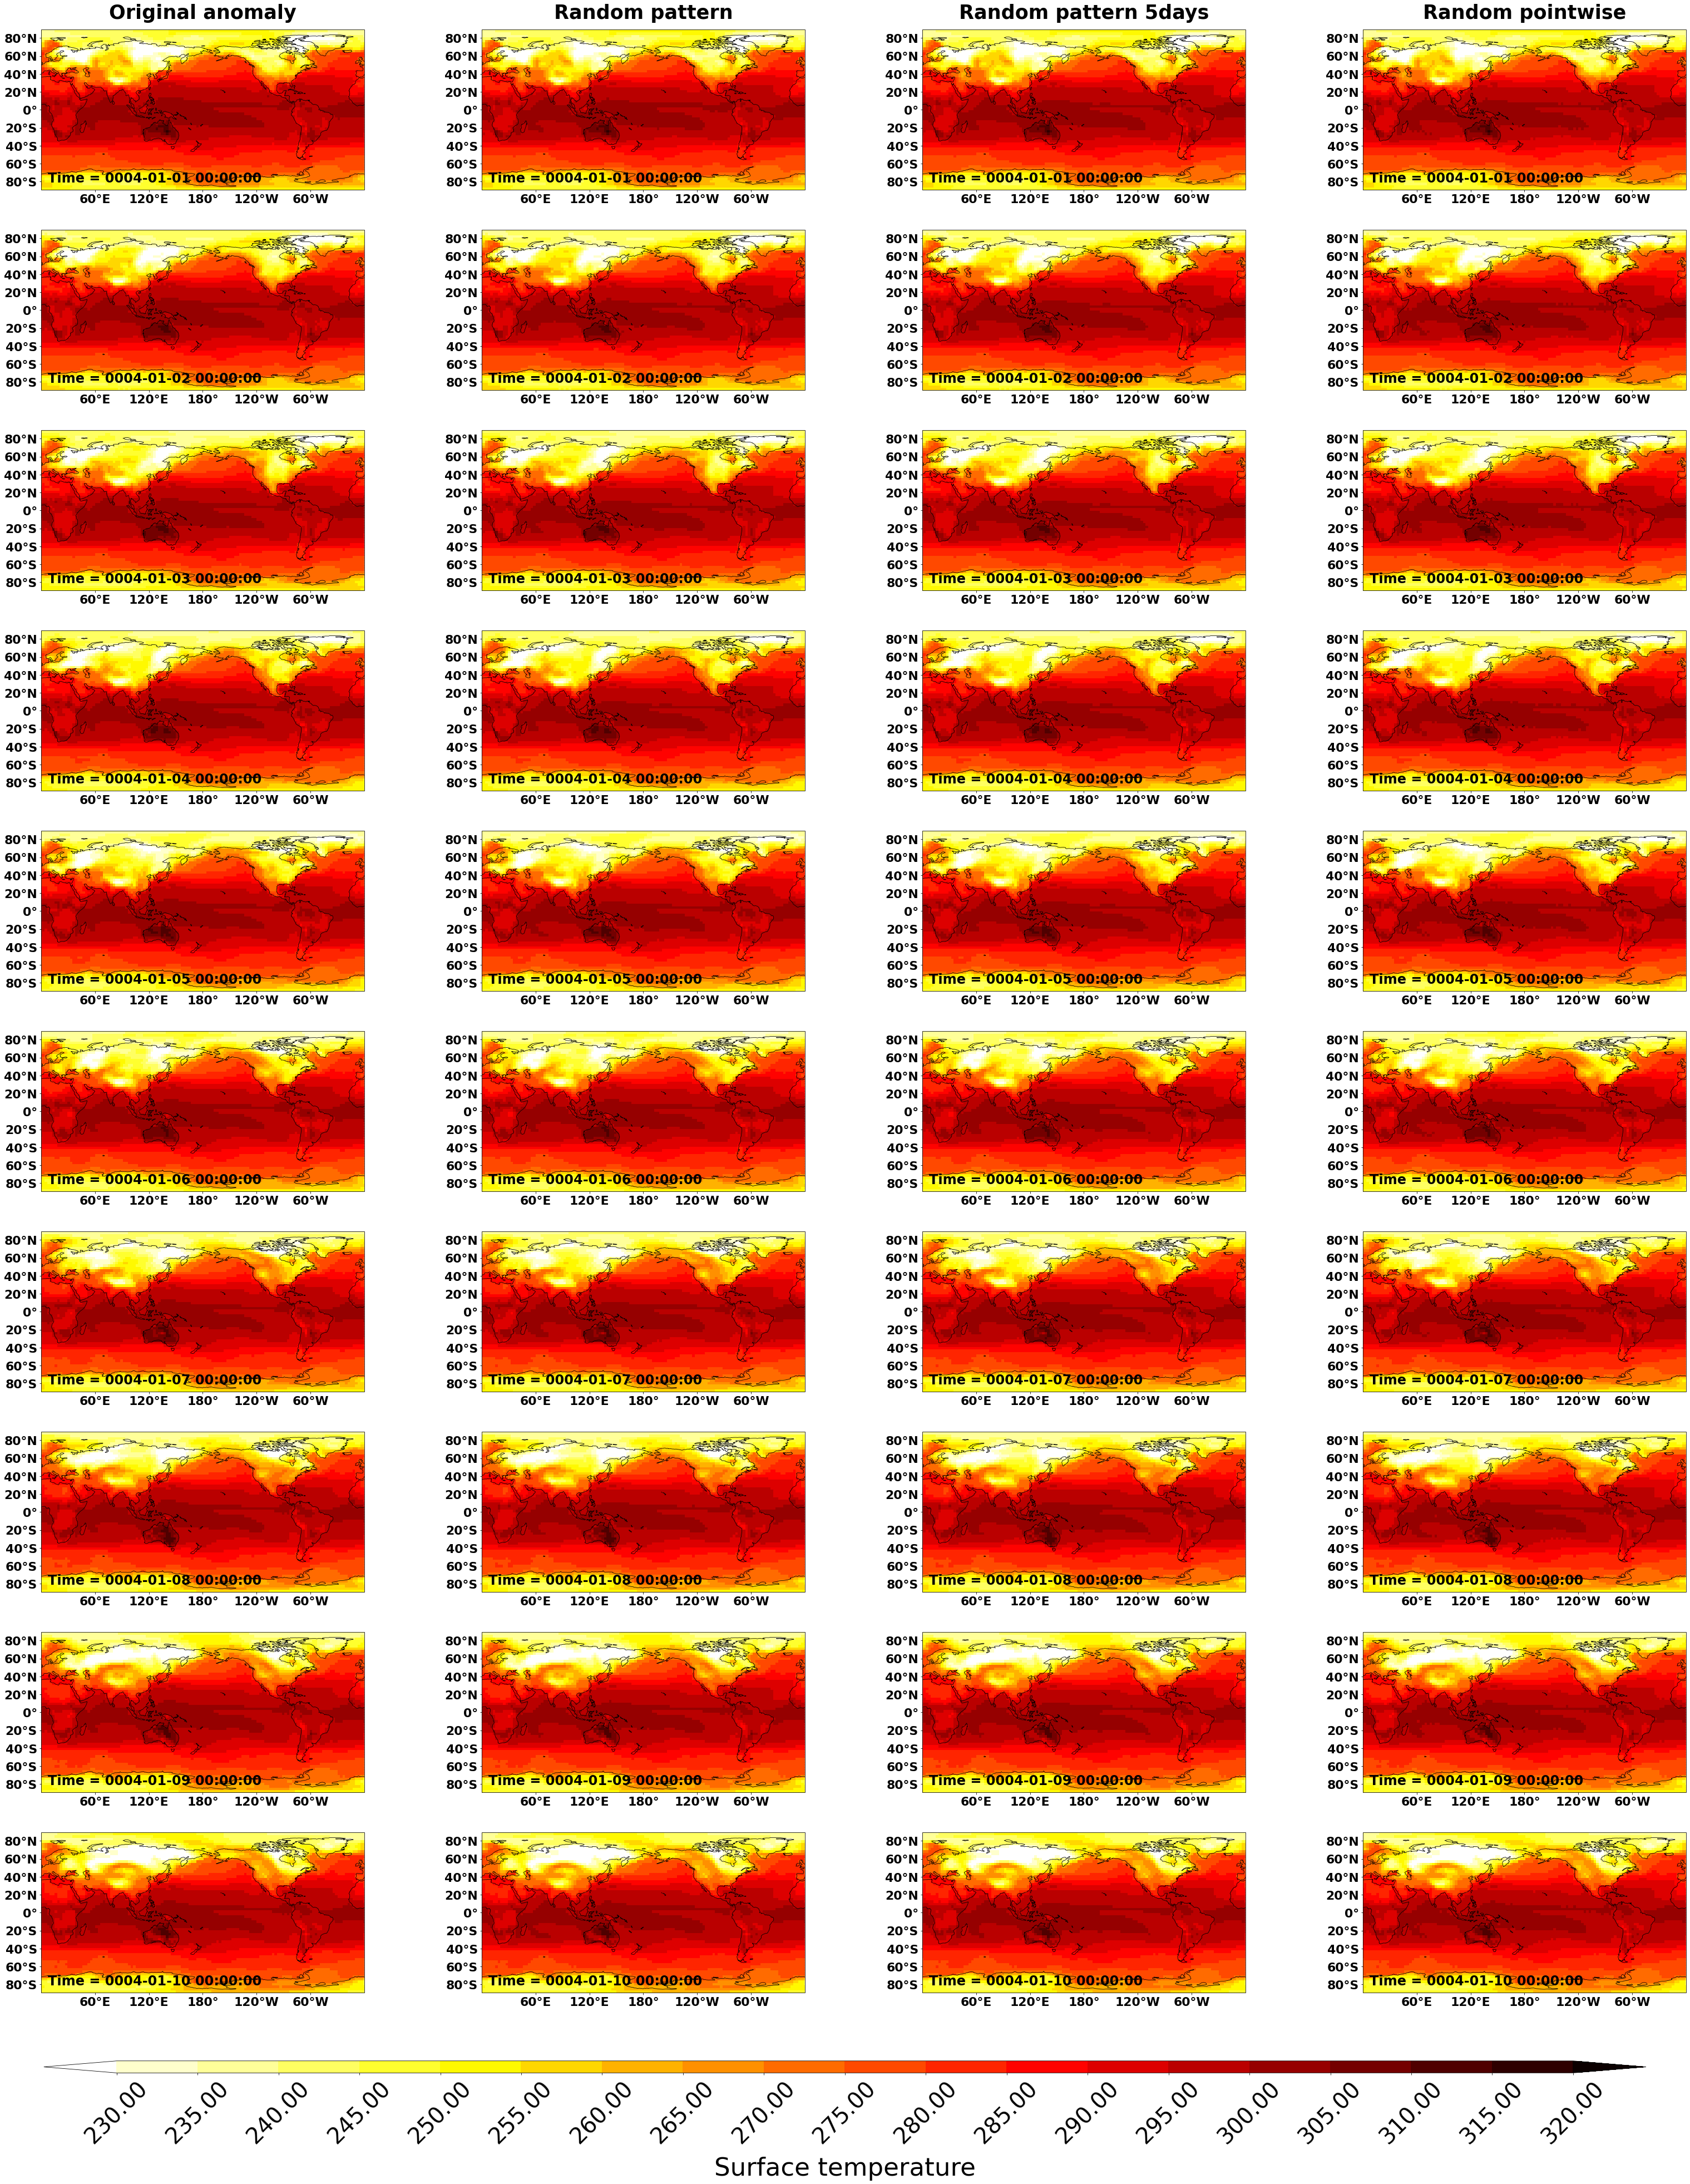

In [178]:
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
# from palettable.colorbrewer.diverging import BrBG_11

fig = plt.figure(2,figsize=(20,10))
devy = 0.5
dlevel = np.arange(230, 320+0.01, 5)
timeindex = np.arange(0,10)


######################################## plotting ############################################
for nindex,timeindex in enumerate(timeindex):
    
    #### original ####
    ax2 = fig.add_axes([0,0-nindex*devy-0.4,1,0.4],projection=ccrs.PlateCarree(central_longitude=180))
    im = ds['%s'%varName].isel(time=timeindex)\
           .plot.pcolormesh(x='lon',
                            y='lat',
                            ax=ax2, 
                            levels=dlevel, 
                            extend='both', 
                            cmap='hot_r',
                            transform=ccrs.PlateCarree(central_longitude=0))

    cb=im.colorbar
    cb.remove()
    ax2.coastlines(resolution='110m',linewidths=0.8)
#     ax2.add_feature(cfeature.LAND,color='lightgrey')
    
    ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
    ax2.set_yticks([-80,-60,-40,-20,0,20,40,60,80], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-80,-60,-40,-20,0,20,40,60,80], color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()
    
    ax2.text(0.02,0.05, 'Time = %s'%ds['%s_ocn_anom'%varName].time.isel(time=timeindex).values,
             fontsize=24, color='k', weight='bold', transform=ax2.transAxes)
    

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
#     ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    if nindex == 0:
        ax2.set_title('Original anomaly', color='black', weight='bold',size=35,pad=20)
    else:
        ax2.set_title('', color='black', weight='bold',size=35,pad=20)
#     ax2.set_aspect('auto')
    
    
    #### random pattern ####
    ax2 = fig.add_axes([0+0.55,0-nindex*devy-0.4,1,0.4],projection=ccrs.PlateCarree(central_longitude=180))
    im = ds['RandPatt1d'].isel(time=timeindex)\
           .plot.pcolormesh(x='lon',
                            y='lat',
                            ax=ax2, 
                            levels=dlevel, 
                            extend='both', 
                            cmap='hot_r',
                            transform=ccrs.PlateCarree(central_longitude=0))

    cb=im.colorbar
    cb.remove()
    ax2.coastlines(resolution='110m',linewidths=0.8)
#     ax2.add_feature(cfeature.LAND,color='lightgrey')
    
    ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
    ax2.set_yticks([-80,-60,-40,-20,0,20,40,60,80], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-80,-60,-40,-20,0,20,40,60,80], color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()
    
    ax2.text(0.02,0.05, 'Time = %s'%ds['%s_ocn_anom'%varName].time.isel(time=timeindex).values,
             fontsize=24, color='k', weight='bold', transform=ax2.transAxes)
    

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
#     ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    if nindex == 0:
        ax2.set_title('Random pattern', color='black', weight='bold',size=35,pad=20)
    else:
        ax2.set_title('', color='black', weight='bold',size=35,pad=20)
#     ax2.set_aspect('auto')

    #### random pattern 5days ####
    ax2 = fig.add_axes([0+0.55*2,0-nindex*devy-0.4,1,0.4],projection=ccrs.PlateCarree(central_longitude=180))
    im = ds['RandPatt5d'].isel(time=timeindex)\
           .plot.pcolormesh(x='lon',
                            y='lat',
                            ax=ax2, 
                            levels=dlevel, 
                            extend='both', 
                            cmap='hot_r',
                            transform=ccrs.PlateCarree(central_longitude=0))

    cb=im.colorbar
    cb.remove()
    ax2.coastlines(resolution='110m',linewidths=0.8)
#     ax2.add_feature(cfeature.LAND,color='lightgrey')
    
    ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
    ax2.set_yticks([-80,-60,-40,-20,0,20,40,60,80], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-80,-60,-40,-20,0,20,40,60,80], color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()
    
    ax2.text(0.02,0.05, 'Time = %s'%ds['%s_ocn_anom'%varName].time.isel(time=timeindex).values,
             fontsize=24, color='k', weight='bold', transform=ax2.transAxes)
    

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
#     ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    if nindex == 0:
        ax2.set_title('Random pattern 5days', color='black', weight='bold',size=35,pad=20)
    else:
        ax2.set_title('', color='black', weight='bold',size=35,pad=20)
#     ax2.set_aspect('auto')

    #### random pointwise ####
    ax2 = fig.add_axes([0+0.55*3,0-nindex*devy-0.4,1,0.4],projection=ccrs.PlateCarree(central_longitude=180))
    im = ds['RandPt1d'].isel(time=timeindex)\
           .plot.pcolormesh(x='lon',
                            y='lat',
                            ax=ax2, 
                            levels=dlevel, 
                            extend='both', 
                            cmap='hot_r',
                            transform=ccrs.PlateCarree(central_longitude=0))

    cb=im.colorbar
    cb.remove()
    ax2.coastlines(resolution='110m',linewidths=0.8)
#     ax2.add_feature(cfeature.LAND,color='lightgrey')
    
    ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
    ax2.set_yticks([-80,-60,-40,-20,0,20,40,60,80], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-80,-60,-40,-20,0,20,40,60,80], color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()
    
    ax2.text(0.02,0.05, 'Time = %s'%ds['%s_ocn_anom'%varName].time.isel(time=timeindex).values,
             fontsize=24, color='k', weight='bold', transform=ax2.transAxes)
    

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
#     ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    if nindex == 0:
        ax2.set_title('Random pointwise', color='black', weight='bold',size=35,pad=20)
    else:
        ax2.set_title('', color='black', weight='bold',size=35,pad=20)
#     ax2.set_aspect('auto')



cbaxes=fig.add_axes([0+0.4,0-nindex*devy-0.6,2,0.03])
cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
cbar.set_ticks(dlevel)
cbar.set_ticklabels(["%0.2f"%(n) for n in dlevel]) 
cbar.ax.tick_params(labelsize=40,rotation=45) 
cbar.set_label(label='Surface temperature',size=45, labelpad=15)



fig.savefig('SST_locking_global_total_demo.png', dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', format=None,
                transparent=False, bbox_inches="tight", pad_inches=None)



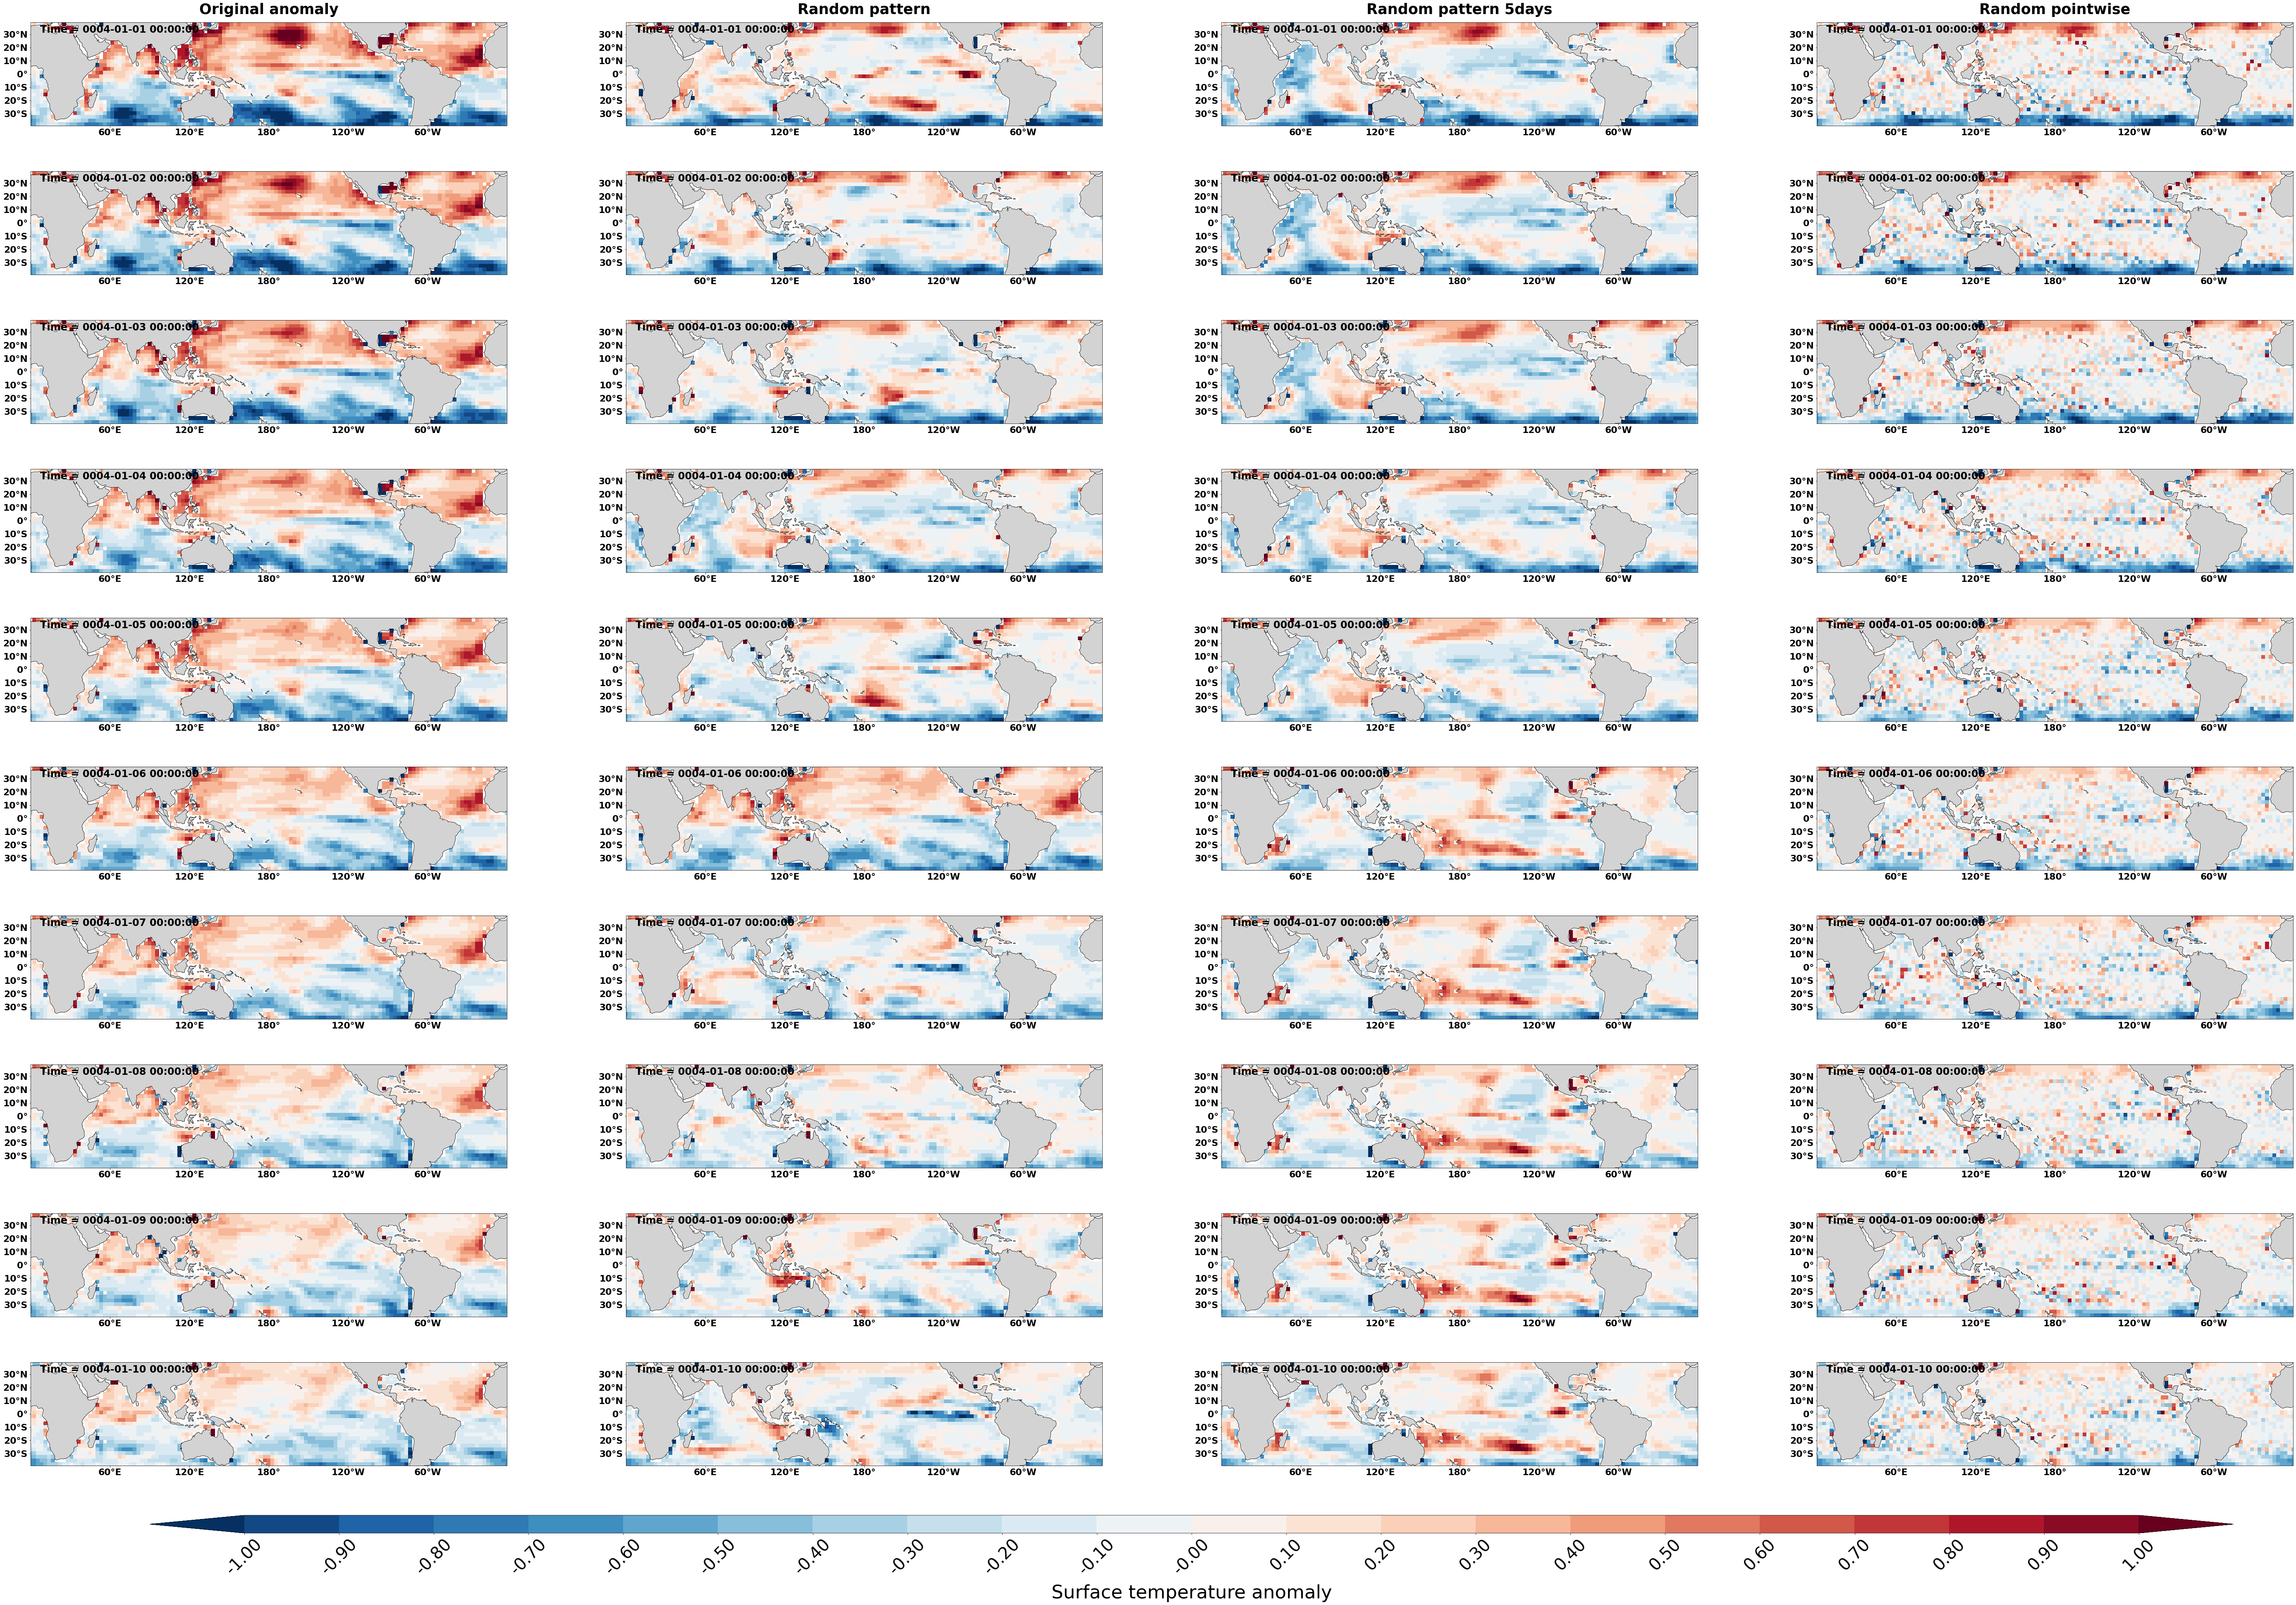

In [173]:
import cartopy.mpl.ticker as cticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
# from palettable.colorbrewer.diverging import BrBG_11

fig = plt.figure(2,figsize=(20,10))
devy = 0.5
dlevel = np.arange(-1, 1+0.01, 0.1)
timeindex = np.arange(0,10)


######################################## plotting ############################################
for nindex,timeindex in enumerate(timeindex):
    
    #### original ####
    ax2 = fig.add_axes([0,0-nindex*devy-0.4,1,0.4],projection=ccrs.PlateCarree(central_longitude=180))
    im = ds['%s_ocn_anom'%varName].where((da_omask_regrid.lat>-40)&(da_omask_regrid.lat<40),drop=True).isel(time=timeindex)\
           .plot.pcolormesh(x='lon',
                            y='lat',
                            ax=ax2, 
                            levels=dlevel, 
                            extend='both', 
                            cmap='RdBu_r',
                            transform=ccrs.PlateCarree(central_longitude=0))

    cb=im.colorbar
    cb.remove()
    ax2.coastlines(resolution='110m',linewidths=0.8)
    ax2.add_feature(cfeature.LAND,color='lightgrey')
    
    ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
    ax2.set_yticks([-30,-20,-10,0,10,20,30], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-30,-20,-10,0,10,20,30], color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()
    
    ax2.text(0.02,0.9, 'Time = %s'%ds['%s_ocn_anom'%varName].time.isel(time=timeindex).values,
             fontsize=24, color='k', weight='bold', transform=ax2.transAxes)
    

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
#     ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    if nindex == 0:
        ax2.set_title('Original anomaly', color='black', weight='bold',size=35,pad=20)
    else:
        ax2.set_title('', color='black', weight='bold',size=35,pad=20)
#     ax2.set_aspect('auto')
    
    
    #### random pattern ####
    ax2 = fig.add_axes([0+1,0-nindex*devy-0.4,1,0.4],projection=ccrs.PlateCarree(central_longitude=180))
    im = da_randpatt_trop.where((da_omask_regrid.lat>-40)&(da_omask_regrid.lat<40),drop=True).isel(time=timeindex)\
           .plot.pcolormesh(x='lon',
                            y='lat',
                            ax=ax2, 
                            levels=dlevel, 
                            extend='both', 
                            cmap='RdBu_r',
                            transform=ccrs.PlateCarree(central_longitude=0))

    cb=im.colorbar
    cb.remove()
    ax2.coastlines(resolution='110m',linewidths=0.8)
    ax2.add_feature(cfeature.LAND,color='lightgrey')
    
    ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
    ax2.set_yticks([-30,-20,-10,0,10,20,30], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-30,-20,-10,0,10,20,30], color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()
    
    ax2.text(0.02,0.9, 'Time = %s'%ds['%s_ocn_anom'%varName].time.isel(time=timeindex).values,
             fontsize=24, color='k', weight='bold', transform=ax2.transAxes)
    

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
#     ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    if nindex == 0:
        ax2.set_title('Random pattern', color='black', weight='bold',size=35,pad=20)
    else:
        ax2.set_title('', color='black', weight='bold',size=35,pad=20)
#     ax2.set_aspect('auto')

    #### random pattern 5days ####
    ax2 = fig.add_axes([0+1*2,0-nindex*devy-0.4,1,0.4],projection=ccrs.PlateCarree(central_longitude=180))
    im = da_randpatt5days_trop.where((da_omask_regrid.lat>-40)&(da_omask_regrid.lat<40),drop=True).isel(time=timeindex)\
           .plot.pcolormesh(x='lon',
                            y='lat',
                            ax=ax2, 
                            levels=dlevel, 
                            extend='both', 
                            cmap='RdBu_r',
                            transform=ccrs.PlateCarree(central_longitude=0))

    cb=im.colorbar
    cb.remove()
    ax2.coastlines(resolution='110m',linewidths=0.8)
    ax2.add_feature(cfeature.LAND,color='lightgrey')
    
    ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
    ax2.set_yticks([-30,-20,-10,0,10,20,30], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-30,-20,-10,0,10,20,30], color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()
    
    ax2.text(0.02,0.9, 'Time = %s'%ds['%s_ocn_anom'%varName].time.isel(time=timeindex).values,
             fontsize=24, color='k', weight='bold', transform=ax2.transAxes)
    

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
#     ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    if nindex == 0:
        ax2.set_title('Random pattern 5days', color='black', weight='bold',size=35,pad=20)
    else:
        ax2.set_title('', color='black', weight='bold',size=35,pad=20)
#     ax2.set_aspect('auto')

    #### random pointwise ####
    ax2 = fig.add_axes([0+1*3,0-nindex*devy-0.4,1,0.4],projection=ccrs.PlateCarree(central_longitude=180))
    im = da_randpt_trop.where((da_omask_regrid.lat>-40)&(da_omask_regrid.lat<40),drop=True).isel(time=timeindex)\
           .plot.pcolormesh(x='lon',
                            y='lat',
                            ax=ax2, 
                            levels=dlevel, 
                            extend='both', 
                            cmap='RdBu_r',
                            transform=ccrs.PlateCarree(central_longitude=0))

    cb=im.colorbar
    cb.remove()
    ax2.coastlines(resolution='110m',linewidths=0.8)
    ax2.add_feature(cfeature.LAND,color='lightgrey')
    
    ax2.set_xticks([60,120,180,240,300], crs=ccrs.PlateCarree())
    ax2.set_xticklabels([60,120,180,-120,-60], color='black', weight='bold',size=22)
    ax2.set_yticks([-30,-20,-10,0,10,20,30], crs=ccrs.PlateCarree())
    ax2.set_yticklabels([-30,-20,-10,0,10,20,30], color='black', weight='bold',size=22)
    ax2.yaxis.tick_left()
    
    ax2.text(0.02,0.9, 'Time = %s'%ds['%s_ocn_anom'%varName].time.isel(time=timeindex).values,
             fontsize=24, color='k', weight='bold', transform=ax2.transAxes)
    

    lon_formatter = cticker.LongitudeFormatter()
    lat_formatter = cticker.LatitudeFormatter()
    ax2.xaxis.set_major_formatter(lon_formatter)
    ax2.yaxis.set_major_formatter(lat_formatter)
#     ax2.grid(linewidth=2, color='black', alpha=0.3, linestyle='--')
    ax2.set_xlabel('')
    ax2.set_ylabel('')
    if nindex == 0:
        ax2.set_title('Random pointwise', color='black', weight='bold',size=35,pad=20)
    else:
        ax2.set_title('', color='black', weight='bold',size=35,pad=20)
#     ax2.set_aspect('auto')



cbaxes=fig.add_axes([0+0.2,0-nindex*devy-0.6,3.5,0.06])
cbar=fig.colorbar(im,cax=cbaxes,orientation='horizontal')
cbar.set_ticks(dlevel)
cbar.set_ticklabels(["%0.2f"%(n) for n in dlevel]) 
cbar.ax.tick_params(labelsize=40,rotation=45) 
cbar.set_label(label='Surface temperature anomaly',size=45, labelpad=15)



fig.savefig('SST_locking_trop_anom_demo.png', dpi=300, facecolor='w', edgecolor='w',
                orientation='portrait', format=None,
                transparent=False, bbox_inches="tight", pad_inches=None)

